# Show ERA5 historical reconstruction for 'good' parameter combinations

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
import glob
from datetime import datetime
from tqdm import tqdm


In [2]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['legend.fontsize'] = 16


### Locate files

In [3]:
# Rounce PyGEM output
rgi_region = '1'
rgi_glac = '26722' # Kennicott (15645), Root (26722)

gcm = 'ERA5'
start_yr = 1940
end_yr = 2022


In [4]:
# csv with valid params
if rgi_glac == '15645':
    csv_file = 'simulations/opt_params/kenn_opt_params.csv' # n=89
elif rgi_glac == '26722':
    csv_file = 'simulations/opt_params/root_opt_params.csv' # n=22

df_params = pd.read_csv(csv_file)
valid_params = list(df_params[['kp', 'tbias', 'ddfsnow']].itertuples(index=False, name=None))


In [5]:
# open dataset (opt params)
fp = f'simulations/opt_params/opt_params_from1940/{gcm}/stats/' # opt params
fn = f'{rgi_region}*{rgi_glac}*{gcm}*{start_yr}*{end_yr}_all.nc'

fls = glob.glob(fp+fn)
nc_datas = []
for f in fls:
    nc_data = xr.open_dataset(f)
    try:
        kp = float(f.split('/')[-1].split('_kp')[1].split('_')[0])
        tbias = float(f.split('/')[-1].split('_tbias')[1].split('_')[0])
        ddfsnow = float(f.split('/')[-1].split('_ddfsnow')[1].split('_')[0])
    except:
        kp, tbias, ddfsnow = 0, 0, 0

    if (kp, tbias, ddfsnow*1000) in valid_params:
        # Add kp, tbias, and ddfsnow as attributes to the dataset
        nc_data.attrs['kp'] = kp
        nc_data.attrs['tbias'] = tbias
        nc_data.attrs['ddfsnow'] = ddfsnow            
        nc_datas.append(nc_data)


### Save the mean values

In [6]:
rho = 900

# convert cftime to datetime for plotting
def cftime_to_datetime(cftime_date):
    return datetime(cftime_date.year, cftime_date.month, cftime_date.day)

In [7]:
all_vol, all_mass, all_area, all_temp, all_prec, all_mb, all_smb = [], [], [], [], [], [], []
for i, nc_data in tqdm(enumerate(nc_datas)):
    glac_no = nc_data.variables['RGIId'][:].values
    cenlon = nc_data.variables['CenLon'][:].values
    cenlat = nc_data.variables['CenLat'][:].values
    o1reg = nc_data.variables['O1Region'][:].values
    o2reg = nc_data.variables['O2Region'][:].values
    cftime = nc_data.variables['time'][:]
    years = nc_data.variables['year'][:]
    months = [cftime_to_datetime(d) for d in np.array(cftime)]

    temp_monthly = nc_data.variables['glac_temp_monthly'][:][0,:]
    prec_monthly = nc_data.variables['glac_prec_monthly'][:][0,:]
    mb_monthly = nc_data.variables['glac_massbaltotal_monthly'][:][0,:]
    area_annual = nc_data.variables['glac_area_annual'][:][0,:]
    mass_annual = nc_data.variables['glac_mass_annual'][:][0,:]
    vol_annual = mass_annual/rho
    vol_annual_km3 = vol_annual/1e9

    ddfsnow = nc_data.ddfsnow # degree-day factor of snow
    kp = nc_data.kp # precipitation factor
    tbias = nc_data.tbias # temperature bias

    # annunal temp and precip
    monnths_yr = np.array([d.year for d in months])
    unique_yr = np.unique(monnths_yr)
    temp_annual, prec_annual, mb_annual = [], [], []
    for yr in unique_yr:
        mask = monnths_yr == yr
        temp_annual.append(np.mean(temp_monthly[mask])-273.15) # also convert kelvin to celsius
        prec_annual.append(np.mean(prec_monthly[mask]))
        mb_annual.append(np.mean(mb_monthly[mask]))
    smb_annual = 1000*np.array(mb_annual/area_annual[:-1]) # specific mb in mm w.e.

    all_vol.append(vol_annual_km3)
    all_mass.append(mass_annual)
    all_area.append(area_annual)
    all_temp.append(temp_annual)
    all_prec.append(prec_annual)
    all_mb.append(mb_annual)
    all_smb.append(smb_annual)
        

# save the mean of all parameter sets
vol_scen_mean = [np.mean(np.vstack(all_vol), axis=0)]
vol_scen_min = [np.min(np.vstack(all_vol), axis=0)]
vol_scen_max = [np.max(np.vstack(all_vol), axis=0)]
mass_scen_mean = [np.mean(np.vstack(all_mass), axis=0)]
mass_scen_min = [np.min(np.vstack(all_mass), axis=0)]
mass_scen_max = [np.max(np.vstack(all_mass), axis=0)]
area_scen_mean = [np.mean(np.vstack(all_area), axis=0)]
area_scen_min = [np.min(np.vstack(all_area), axis=0)]
area_scen_max = [np.max(np.vstack(all_area), axis=0)]
mb_scen_mean = [np.mean(np.vstack(all_mb), axis=0)]
mb_scen_min = [np.min(np.vstack(all_mb), axis=0)]
mb_scen_max = [np.max(np.vstack(all_mb), axis=0)]
smb_scen_mean = [np.mean(np.vstack(all_smb), axis=0)]
smb_scen_min = [np.min(np.vstack(all_smb), axis=0)]
smb_scen_max = [np.max(np.vstack(all_smb), axis=0)]
temp_scen_mean = [np.mean(np.vstack(all_temp), axis=0)]
prec_scen_mean = [np.mean(np.vstack(all_prec), axis=0)]

# create an xarray dataset
ds = xr.Dataset({ "RGIId": (["glac"], glac_no), "CenLon": (["glac"], cenlon), "CenLat": (["glac"], cenlat),
                 "O1Region": (["glac"], o1reg), "O2Region": (["glac"], o2reg), "glac_area_annual_mean": (["glac", "year"], area_scen_mean), 
                 "glac_area_annual_min": (["glac", "year"], area_scen_min), "glac_area_annual_max": (["glac", "year"], area_scen_max), 
                 "glac_mass_annual_mean": (["glac", "year"], mass_scen_mean), "glac_mass_annual_min": (["glac", "year"], mass_scen_min), 
                 "glac_mass_annual_max": (["glac", "year"], mass_scen_max), "glac_vol_annual_mean": (["glac", "year"], vol_scen_mean), 
                 "glac_vol_annual_min": (["glac", "year"], vol_scen_min), "glac_vol_annual_max": (["glac", "year"], vol_scen_max),
                 "glac_mb_annual_mean": (["glac", "year_unique"], mb_scen_mean), "glac_mb_annual_min": (["glac", "year_unique"], mb_scen_min), 
                 "glac_mb_annual_max": (["glac", "year_unique"], mb_scen_max), "glac_smb_annual_mean": (["glac", "year_unique"], smb_scen_mean), 
                 "glac_smb_annual_min": (["glac", "year_unique"], smb_scen_min), "glac_smb_annual_max": (["glac", "year_unique"], smb_scen_max),
                 "glac_temp_annual_mean": (["glac", "year_unique"], temp_scen_mean), "glac_prec_annual_mean": (["glac", "year_unique"], prec_scen_mean)},
                coords={"glac": [0], "time": cftime, "year": years, "month": months, "year_unique": unique_yr})


22it [00:00, 24.61it/s]


### Extract and plot results

In [9]:
kenn_farinotti_km3 = 62.9 # consensus volume in 2000
root_farinotti_km3 = 14.8 # consensus volume in 2000

kenn_hug_km3 = 62.9 - 2.76 # hugonnet volume in 2020
root_hug_km3 = 14.8 - 0.84 # hugonnet volume in 2020


In [10]:
rho = 900
cmap = cmocean.cm.amp
lss = ['-', '--', '-.', ':']


Locate Rounce et al. (2023) results as well

In [11]:
# Rounce PyGEM output
option_calib = 'MCMC'

# open dataset
fp = 'simulations/gridsearch/rounce_mcmc_from1940/' + gcm + '/stats/'
fn = f'{rgi_region}*{rgi_glac}*{gcm}*{option_calib}*{start_yr}*{end_yr}_all.nc'
fl = glob.glob(fp+fn)
print(fl)

assert len(fl) == 1, f"Expected exactly one file match, but found {len(fl)} files."
rounce_nc_data = xr.open_dataset(fl[0])


['simulations/gridsearch/rounce_mcmc_from1940/ERA5/stats/1.26722_ERA5_MCMC_ba0_1sets_1940_2022_all.nc']


In [12]:
# extract data    
glac_no_r = rounce_nc_data.variables['RGIId'][:].values[0]
cftime_r = rounce_nc_data.variables['time'][:]
years_r = rounce_nc_data.variables['year'][:]

months_r = [cftime_to_datetime(d) for d in np.array(cftime_r)]
temp_monthly_r = rounce_nc_data.variables['glac_temp_monthly'][:][0,:]
prec_monthly_r = rounce_nc_data.variables['glac_prec_monthly'][:][0,:]
area_annual_r = rounce_nc_data.variables['glac_area_annual'][:][0,:]
mass_annual_r = rounce_nc_data.variables['glac_mass_annual'][:][0,:]
mass_annual_Gt_r = mass_annual_r/1e12
vol_annual_r = mass_annual_r/rho
vol_annual_km3_r = vol_annual_r/1e9

# annunal temp and precip
months_yr_r = np.array([d.year for d in months_r])
unique_yr_r = np.unique(months_yr_r)
temp_annual_r, prec_annual_r = [], []
for yr in unique_yr_r:
    mask_r = months_yr_r == yr
    temp_annual_r.append(np.mean(temp_monthly_r[mask_r])-273.15) # also convert kelvin to celsius
    prec_annual_r.append(np.mean(prec_monthly_r[mask_r]))
        

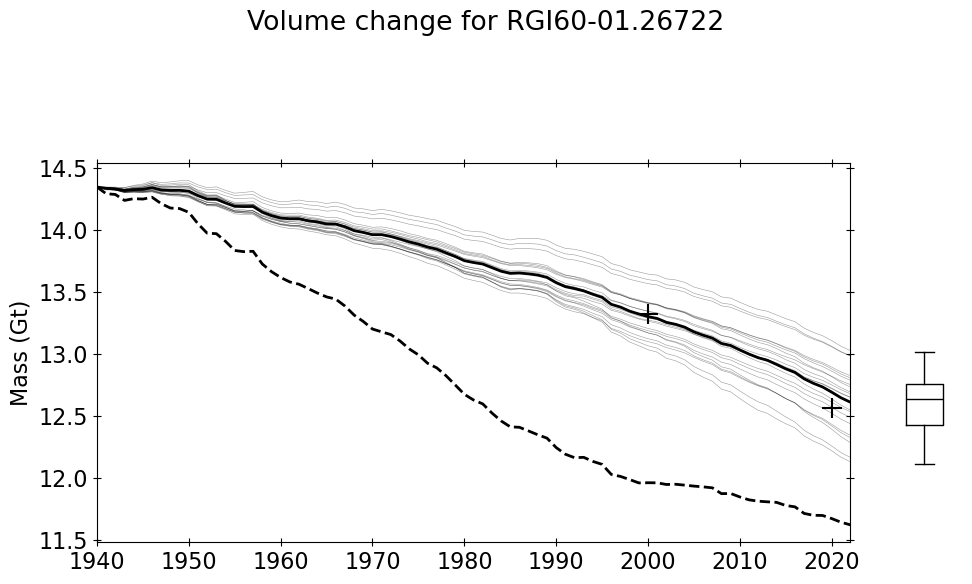

In [16]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[10, 1], height_ratios=[1, 6])
gs1 = fig.add_subplot(gs[0, 0])
gs2 = fig.add_subplot(gs[0, 1], sharey=gs1)
gs3 = fig.add_subplot(gs[1, 0], sharex=gs1)
gs4 = fig.add_subplot(gs[1, 1], sharey=gs3, sharex=gs2)
axes = gs3
axbox = gs4

n = len(nc_datas)

# plot Rounce MCMC calibration
l3, = axes.plot(years_r, mass_annual_Gt_r, c='k', ls='--', lw=2, alpha=1, label='Modern calibration', zorder=100)

# plot data
all_vol, vol_2100 = [], []
for i, nc_param in enumerate(nc_datas):
    glac_no = nc_param.variables['RGIId'][:].values[0]
    cftime = nc_param.variables['time'][:]
    years = nc_param.variables['year'][:]
    months = [cftime_to_datetime(d) for d in np.array(cftime)]
    
    temp_monthly = nc_param.variables['glac_temp_monthly'][:][0,:]
    prec_monthly = nc_param.variables['glac_prec_monthly'][:][0,:]
    area_annual = nc_param.variables['glac_area_annual'][:][0,:]
    mass_annual = nc_param.variables['glac_mass_annual'][:][0,:]
    mass_annual_Gt = mass_annual/1e12
    vol_annual = mass_annual/rho
    vol_annual_km3 = vol_annual/1e9

    ddfsnow = nc_param.ddfsnow # degree-day factor of snow
    kp = nc_param.kp # precipitation factor
    tbias = nc_param.tbias # temperature bias


    vol_2100.append(mass_annual_Gt[-1])
    all_vol.append(mass_annual_Gt)
    l1, = axes.plot(years, mass_annual_Gt, c='k', ls='-', lw=0.4, alpha=0.4)#, label=f'{gcm_name}')

    
axes.plot([], [], c='k', ls='-', lw=0.5, alpha=0.9, label='Historical calibration (individual)')
# vol_2100_box.append(vol_2100)

# plot mean of MCMC GCMs for each SSP
vol_optparam_median = np.median(np.vstack(all_vol), axis=0)
vol_optparam_mean = np.mean(np.vstack(all_vol), axis=0)
vol_optparam_min = np.min(np.vstack(all_vol), axis=0)
vol_optparam_max = np.max(np.vstack(all_vol), axis=0)
l2, = axes.plot(years, vol_optparam_mean, c='k', ls='-', lw=2, alpha=1, label='Historical calibration (mean)')
if i==0:
    axes.plot([],[], c='k', ls=lss[0], label=f'MCMC params')
     
# box-and-whisker plots
boxplot_y = 6
box = axbox.boxplot(np.array(vol_2100), widths=0.5, showfliers=False)
axbox.axis('off')
for i, (label, boxplot, meds) in enumerate(zip(['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5'], box['boxes'], box['medians'])):
    axbox.annotate(label, (boxplot.get_xdata()[0], boxplot_y), xytext=(3,0), textcoords='offset points', 
                     va='top', ha='center', rotation=90, size=12) 
    boxplot.set_color('k') # fix colors
    meds.set_color('k')

for i, (whisker, cap) in enumerate(zip(box['whiskers'], box['caps'])): # whisker and cap color
    whisker.set_color('k')
    cap.set_color('k')

# add volume observation
if glac_no == 'RGI60-01.15645':
    axes.scatter(2000, kenn_farinotti_km3*rho/1e3, c='k', s=200, marker='+', zorder=50, label='Consensus volume')
    axes.scatter(2020, kenn_hug_km3*rho/1e3, c='k', s=200, marker='+', zorder=50)
elif glac_no == 'RGI60-01.26722':
    axes.scatter(2000, root_farinotti_km3*rho/1e3, c='k', s=200, marker='+', zorder=50, label='Consensus volume')
    axes.scatter(2020, root_hug_km3*rho/1e3, c='k', s=200, marker='+', zorder=50)

# set labels
axes.set_ylabel('Mass (Gt)') 
axes.set_xlim(start_yr, end_yr)
axes.tick_params(axis='both', which='both', direction='inout', right=True, top=True, length=6)

# add legend
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes.legend(loc='lower left')
# axes.annotate(f'f_snow: {ddfsnow}\nk_p: {kp}\nT_bias: {tbias}', (0.02,0.05), xycoords='axes fraction', c='k', size=12)

gs1.axis('off')
gs2.axis('off')
fig.tight_layout()
plt.show()
